In [1]:
import pandas as pd
import numpy as np 
import json
import os
from pprint import pprint
from konlpy.tag import Mecab

### data 추출 - 예제 코드입니다. 

- 아래 데이터셋은 0이 19000개 1이 500개정도 이루어진 불균형한 레이블 구성의 데이터셋입니다. 어디까지나 테스트용 리뷰셋입니다.

In [2]:
data1 = pd.read_excel('샴푸샴푸세정력.xlsx')
data2 = data1.loc[:,['review','pos']]
data2.dropna(subset=['review'],inplace=True)

### sklearn - data split

In [3]:
from sklearn.model_selection import train_test_split

class_df = data2['pos']
feature_df = data2.drop(['pos'], axis=1, inplace=False)

X_train, X_test, y_train, y_test= train_test_split(feature_df, class_df, test_size=0.3, random_state=156)
X_train.shape, X_test.shape

((13917, 1), (5965, 1))

## 리뷰데이터 -> 리스트 /// because of vector화

In [4]:
X_train_list = []
for review in X_train['review']:
    X_train_list.append(review)
    
X_test_list = []
for review in X_test['review']:
    X_test_list.append(review)

In [5]:
X_train_list[1]

'넘좋아요\n저렴하게구입했네요'

# model- Logistic Regression
## CountVectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vect = CountVectorizer()
cnt_vect.fit(X_train_list,y_train)
X_train_cnt_vect = cnt_vect.transform(X_train_list)

X_test_cnt_vect = cnt_vect.transform(X_test_list)

print('학습 데이터 Text의 CountVectorizer Shape:',X_train_cnt_vect.shape)

학습 데이터 Text의 CountVectorizer Shape: (13917, 37521)


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train_cnt_vect, y_train)
pred = lr_clf.predict(X_test_cnt_vect)
print('CountVectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test,pred)))

/home/daehynk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CountVectorized Logistic Regression 의 예측 정확도는 0.991


## TF-IDF vector 화

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization 적용하여 학습 데이터셋과 테스트 데이터 셋 변환. 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(X_train_list)
X_train_tfidf_vect = tfidf_vect.transform(X_train_list)
X_test_tfidf_vect = tfidf_vect.transform(X_test_list)

print('학습 데이터 Text의 CountVectorizer Shape:',X_train_tfidf_vect.shape)

학습 데이터 Text의 CountVectorizer Shape: (13917, 37521)


In [9]:
# LogisticRegression을 이용하여 학습/예측/평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train_tfidf_vect , y_train)
pred = lr_clf.predict(X_test_tfidf_vect)
print('TF-IDF Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))

/home/daehynk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


TF-IDF Logistic Regression 의 예측 정확도는 0.986


## GridSearchCV 활용한 파라미터 최적화 

In [12]:
import time
from sklearn.model_selection import GridSearchCV

start_time = time.time()

# 최적 C 값 도출 튜닝 수행. CV는 3 Fold셋으로 설정. 
params = { 'C':[0.01, 0.1, 1, 5, 10]}
grid_cv_lr = GridSearchCV(lr_clf ,param_grid=params , cv=3 , scoring='accuracy' , verbose=1 )
grid_cv_lr.fit(X_train_tfidf_vect , y_train)
print('Logistic Regression best C parameter :',grid_cv_lr.best_params_ )

# 최적 C 값으로 학습된 grid_cv로 예측 수행하고 정확도 평가. 
pred = grid_cv_lr.predict(X_test_tfidf_vect)
print('TF-IDF Vectorized Logistic Regression 의 예측 정확도는 {0:.3f}'.format(accuracy_score(y_test ,pred)))
print("GridSearch CV 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/daehynk/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression best C parameter : {'C': 10}
TF-IDF Vectorized Logistic Regression 의 예측 정확도는 0.992
GridSearch CV 수행 시간: 1.3 초 


[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    1.2s finished


## 변수명으로 모델 저장해서 불러보기

In [31]:
import pickle 

saved_model = pickle.dumps(grid_cv_lr)

In [32]:
grid_cv_lr_from_pickle = pickle.loads(saved_model)

In [39]:
grid_cv_lr_from_pickle.predict(X_train_tfidf_vect)

array([0, 0, 0, ..., 0, 0, 0])

## 모델 파일에 저장하여 로딩해보기

In [40]:
from sklearn.externals import joblib

/home/daehynk/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [41]:
joblib.dump(grid_cv_lr,'testmodel01.pkl')

['testmodel01.pkl']

In [43]:
grid_cv_lr_from_joblib = joblib.load('testmodel01.pkl')
predict_answer = grid_cv_lr_from_joblib.predict(X_train_tfidf_vect)

In [47]:
predict_answer[100:130]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
for answer in predict_answer[100:110]:
    print(answer)

0
0
0
0
0
0
0
0
0
0


## 2. keras - 감성분석

In [65]:
import json
import os
from pprint import pprint
from konlpy.tag import Mecab

mecab = Mecab()

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in mecab.pos(doc)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json') as f:
        train_docs = json.load(f)
    with open('test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row),label ) for row,label in zip(X_train['review'],y_train)]
    test_docs = [(tokenize(row),label ) for row,label in zip(X_test['review'],y_test)]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

[['최고/NNG',
  '입니다/VCP+EF',
  '역시/MAJ',
  '바티스트/NNG',
  '만큼/JKB',
  '가/JKS',
  '성비/NNG',
  '좋/VA',
  '고/EC',
  '좋/VA',
  '은/ETM',
  '드라이/NNG',
  '샴푸/NNG',
  '가/JKS',
  '없/VA',
  '는/ETM',
  '것/NNB',
  '같/VA',
  '아요/EF',
  '몇/MM',
  '통/NNBC',
  '째/XSN',
  '구매/NNG',
  '인지/VCP+EC',
  '기억/NNG',
  '도/JX',
  '안/MAG',
  '나/VV',
  '네여/EF',
  '머리/NNG',
  '가/JKS',
  '길/VA',
  '어서/EC',
  '매일/MAG',
  '감기/NNG',
  '가/JKS',
  '든/VV+ETM',
  '데/NNB',
  '늘/MAG',
  '쟁여/VV+EC',
  '뒀/VX+EP',
  '다가/EC',
  '유용/NNG',
  '하/XSV',
  '게/EC',
  '사용/NNG',
  '합니다/XSV+EC'],
 0]


In [57]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

import nltk
text = nltk.Text(tokens,name='세정력')
print(text)

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

360867
<Text: 세정력>
360867
10299
[('좋/VA', 12868),
 ('고/EC', 10269),
 ('이/JKS', 6630),
 ('도/JX', 6586),
 ('에/JKB', 5825),
 ('샴푸/NNG', 4438),
 ('는/ETM', 4308),
 ('어요/EF', 4255),
 ('아요/EF', 4125),
 ('가/JKS', 3970)]


In [58]:
selected_words = [f[0] for f in text.vocab().most_common(10000)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [59]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [60]:
x_val = x_train[:2000]
partial_x_train = x_train[2000:]
y_val = y_train[:2000]
partial_y_train = y_train[2000:]

In [61]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

history = model.fit(x_train, y_train, epochs=10, batch_size=512,validation_data=(x_val,y_val))
results = model.evaluate(x_test, y_test)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 13917 samples, validate on 2000 samples
Epoch 1/10
13917/13917 [==============================] - 2s 130us/sample - loss: 0.2981 - binary_accuracy: 0.9509 - val_loss: 0.1983 - val_binary_accuracy: 0.9820
Epoch 2/10
13917/13917 [==============================] - 2s 108us/sample - loss: 0.1426 - binary_accuracy: 0.9846 - val_loss: 0.1045 - val_binary_accuracy: 0.9820
Epoch 3/10
13917/13917 [==============================] - 2s 127us/sample - loss: 0.0716 - binary_accuracy: 0.9846 - val_loss: 0.0453 - val_binary_accuracy: 0.9900
Epoch 4/10
13917/13917 [==============================] - 2s 124us/sample - loss: 0.0346 - binary_accuracy: 0.9895 - val_loss: 0.0186 - val_binary_accuracy: 0.9970
Epoch 5/10
13917/13917 [==============================] - 2s 139us/sample - loss: 0.0176 - binary_accuracy: 0.9951 - val_loss: 0.0091 - val_binary_accuracy: 0.9990
Epoch 6/10
13

In [62]:
results

[0.1211377644423988, 0.987762]

In [66]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [67]:
predict_pos_neg("뽀득하고 세정이 잘 되는거 같아요.")

[뽀득하고 세정이 잘 되는거 같아요.]는 85.39% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^



In [68]:
predict_pos_neg("세정력 좋아요 향은 별로네요 두피가 시원해요")

[세정력 좋아요 향은 별로네요 두피가 시원해요]는 99.86% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;



In [69]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

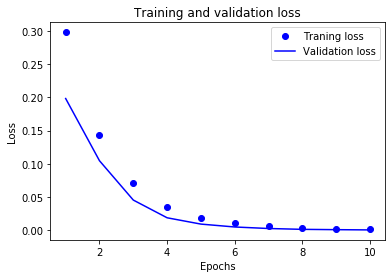

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1,len(loss) +1)

plt.plot(epochs, loss, 'bo', label='Traning loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

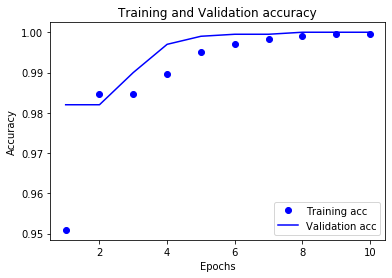

In [71]:
plt.clf()
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()